In [1]:
import yake
import sys
from bs4 import BeautifulSoup
from bs4.element import Comment
import urllib.request
import requests
import time
from IPy import IP
from collections import defaultdict
import itertools  #used to slice a dictionary
import networkx as nx #networkx library for graph creation and clustering
import matplotlib.pyplot as plt  
import community

import json
import pickle

In [2]:
scale_community_spacing = 1.2

def community_layout(g, partition):
    # Compute the layout for a modular graph.
    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = scale_community_spacing * pos_communities[node] + pos_nodes[node]

    return pos

In [35]:
def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=max(2, len(edges)))
        

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

In [4]:
def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

In [5]:
def _position_nodes(g, partition, **kwargs):

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [6]:
# load keywords clustering graph
graph_filename = 'graph.gml'

try:
    graph_keywords = nx.read_gml(graph_filename)
except:
    graph_keywords = nx.Graph()

In [7]:
# load new keywords to cluster
with open('./data/to_cluster.data', 'rb') as file:
    new_keywords_to_cluster = pickle.load(file)
    
new_keywords_to_cluster

[['stocks', 'stock', 'search', 'market', 'ago'],
 ['stocks', 'stock', 'search', 'market', 'ago'],
 ['stock', 'apr.', 'screener', 'updated', 'stocks'],
 ['apr', 'wed', 'market', 'politics', 'stock'],
 ['essentials', 'investing', 'stock', 'trading', 'management'],
 ['bipartite', 'graph', 'search', 'google', 'past'],
 ['bipartite', 'graph', 'returns', 'nodes', 'networkx'],
 ['bipartite', 'graphs', 'graph', 'vertices', 'length'],
 ['tennis', 'search', 'google', 'hours', 'past'],
 ['wta', 'rankings', 'tennis', 'view', 'virtual'],
 ['stocks', 'stock', 'search', 'market', 'ago'],
 ['stock', 'apr.', 'screener', 'updated', 'stocks'],
 ['apr', 'wed', 'market', 'politics', 'stock'],
 ['essentials', 'investing', 'stock', 'trading', 'management'],
 ['bipartite', 'graph', 'search', 'google', 'past'],
 ['bipartite', 'graph', 'returns', 'nodes', 'networkx'],
 ['bipartite', 'graphs', 'graph', 'vertices', 'length'],
 ['tennis', 'search', 'google', 'hours', 'past'],
 ['wta', 'rankings', 'tennis', 'view',

In [8]:
# adding edges between keywords from same page

for same_page in new_keywords_to_cluster:
    for word_i in same_page: 
        for word_j in same_page:
            graph_keywords.add_nodes_from([word_i, word_j])
            if word_i != word_j:
                graph_keywords.add_edge(word_i, word_j)

In [9]:
# print('time taken : ')
# print(end_time - start_time)
# print('url processed : ')
# print(i)

In [10]:
graph_keywords.nodes()

NodeView(('stocks', 'stock', 'search', 'market', 'ago', 'apr.', 'screener', 'updated', 'apr', 'wed', 'politics', 'essentials', 'investing', 'trading', 'management', 'bipartite', 'graph', 'google', 'past', 'returns', 'nodes', 'networkx', 'graphs', 'vertices', 'length', 'tennis', 'hours', 'wta', 'rankings', 'view', 'virtual', 'nadal', 'rafael', 'murray', 'andy'))

In [36]:
#from networkx.algorithms import community

clusters = community.best_partition(graph_keywords, resolution=1.5)
pos = community_layout(graph_keywords, clusters)

In [37]:
clusters

{'stocks': 0,
 'stock': 0,
 'search': 1,
 'market': 0,
 'ago': 0,
 'apr.': 0,
 'screener': 0,
 'updated': 0,
 'apr': 0,
 'wed': 0,
 'politics': 0,
 'essentials': 0,
 'investing': 0,
 'trading': 0,
 'management': 0,
 'bipartite': 2,
 'graph': 2,
 'google': 1,
 'past': 1,
 'returns': 2,
 'nodes': 2,
 'networkx': 2,
 'graphs': 2,
 'vertices': 2,
 'length': 2,
 'tennis': 1,
 'hours': 1,
 'wta': 1,
 'rankings': 1,
 'view': 1,
 'virtual': 1,
 'nadal': 1,
 'rafael': 1,
 'murray': 1,
 'andy': 1}

In [38]:
# save clustering
with open('./data/partition.data', 'wb') as outfile:
    pickle.dump(clusters, outfile)
    
# save graph
nx.write_gml(graph_keywords, './data/graph.gml')

In [40]:
labels = {}
for word in clusters:
    labels[word]=word

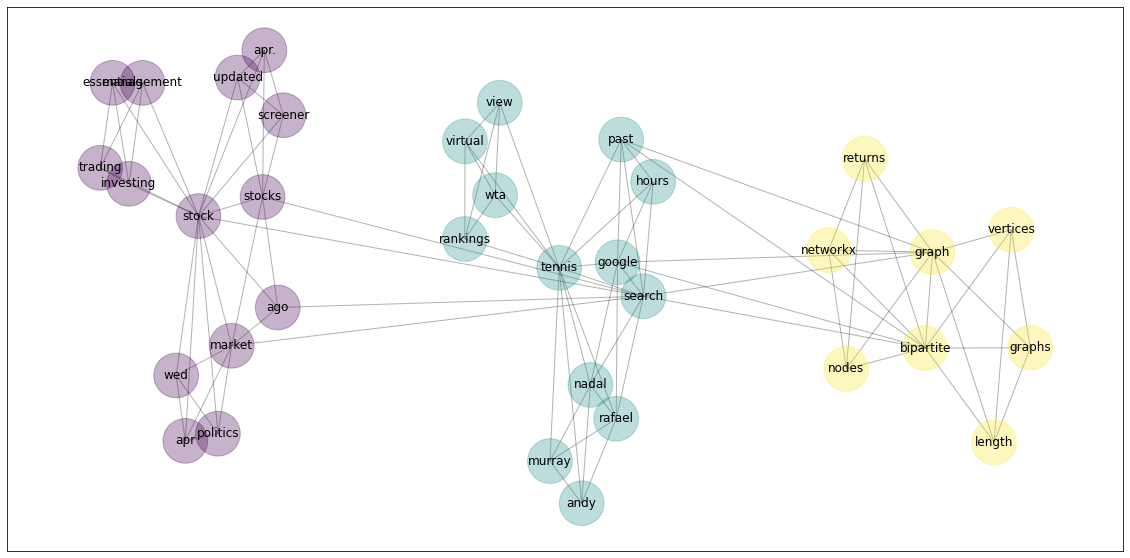

In [42]:
cut = 1.2
xmax= cut*max(xx for xx,yy in pos.values())
xmin= cut*min(xx for xx,yy in pos.values())

ymax= cut*max(yy for xx,yy in pos.values())
ymin= cut*min(yy for xx,yy in pos.values())

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.rcParams["figure.figsize"] = (20,10)

nx.draw_networkx(graph_keywords, pos, node_color=list(clusters.values()), node_size=2000, alpha = 0.3, with_labels=False)

nx.draw_networkx_labels(graph_keywords, pos, labels)

plt.show()